In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
data = pd.read_csv('dataset_cian_itog.csv')

Рассмотрим данные на наличие пропусков и в каких признаках эти пропуски находятся

In [29]:
data.isnull().sum()

Unnamed: 0            0
room                 19
floor                18
floor_counts         18
square               13
price                25
metro_foot_minute     1
zone                  0
district             80
metro                 8
dtype: int64

Пропуски есть во многих признаках и логически сложно их заполнить, а также их не критически много, поэтому мы приняли решение просто удалить строчки с пропусками

In [30]:
data = data.dropna()

In [31]:
data = data.drop('Unnamed: 0', axis=1)

In [32]:
data_final = data[data['room'].isin([1, 2, 3])]

In [33]:
data_final.head(10)

,room,floor,floor_counts,square,price,metro_foot_minute,zone,district,metro
0,2.0,22.0,34.0,50.60,59236384.0,14.0,ЗАО,Дорогомилово,Кутузовская
1,3.0,7.0,10.0,190.00,139000000.0,5.0,ЦАО,Басманный,Бауманская
2,2.0,2.0,14.0,85.60,156750000.0,2.0,ЦАО,Якиманка,Боровицкая
3,3.0,3.0,15.0,104.00,65200000.0,7.0,САО,Аэропорт,Динамо
4,2.0,4.0,13.0,86.28,101797752.0,8.0,ЦАО,Мещанский,Цветной бульвар
5,2.0,7.0,12.0,78.00,102999000.0,6.0,ЦАО,Хамовники,Фрунзенская
6,2.0,8.0,9.0,64.50,89010000.0,1.0,ЦАО,Тверской,Маяковская
7,3.0,5.0,21.0,116.80,120000000.0,7.0,ЦАО,Пресненский,Улица 1905 года
8,2.0,3.0,27.0,58.00,30272464.0,18.0,ЮАО,Даниловский,Серпуховская
9,3.0,5.0,21.0,116.78,120000000.0,7.0,ЦАО,Пресненский,Улица 1905 года


## Предсказание стоимости квартиры по нескольким признакам

Мы решили спарсить данные с Циан, выделить основные признаки, выдвинуть гипотезы и обучить модель линейной регрессии, чтобы по основным характеристикам предсказывать цену квартиры 

Описание переменных:
- `room` - количество комнат в квартире (от 1 до 3)
- `floor` - этаж, на котором располагается квартира
- `floor_counts` - общее количество этажей в доме
- `square` - площадь квартиры в квадратных метрах
- `price` - цена квартиры в рублях
- `metro_foot_minute` - расстояние до ближайшей станции метро в минутах ходьбы
- `zone` - административный округ Москвы
- `district` - район Москвы
- `metro` - ближайшая станция метро

Произведём первоначальный анализ признаков: для числовых построим корреляционную матрицу, а для вещественных построим гистограмму распределения

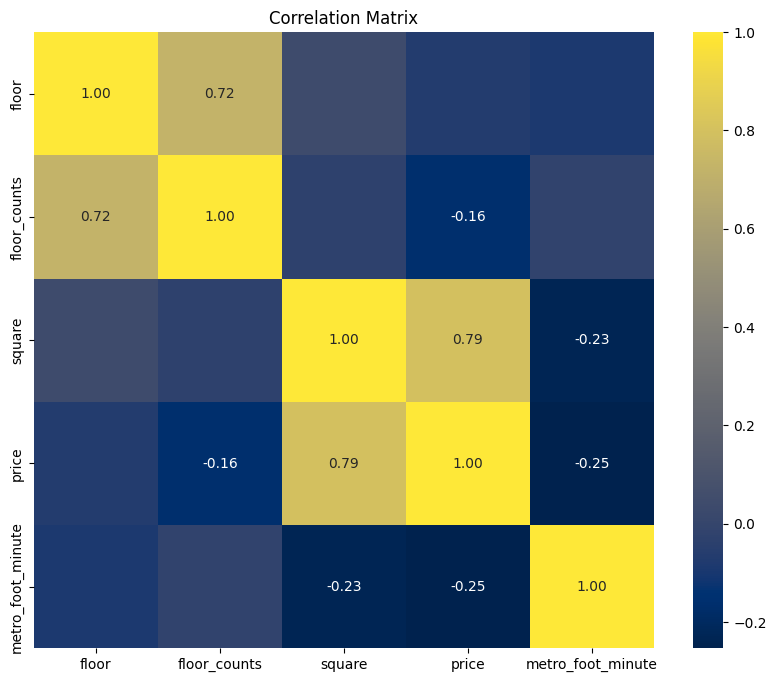

In [34]:
data_num_features = data_final.iloc[:, 1:6]
correlation_matrix = data_num_features.corr()
plt.figure(figsize=(10, 8))
map = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='cividis')
for t in map.texts:
    if float(t.get_text()) >= 0.1 or float(t.get_text()) <= -0.1:
        t.set_text(t.get_text())
    else:
        t.set_text("")
plt.title('Correlation Matrix')
plt.show()

Мы видим, что есть сильная положительная взаимосвязь цены с площадью квартиры, а также заметная отрицательная связь с расстоянием до метро

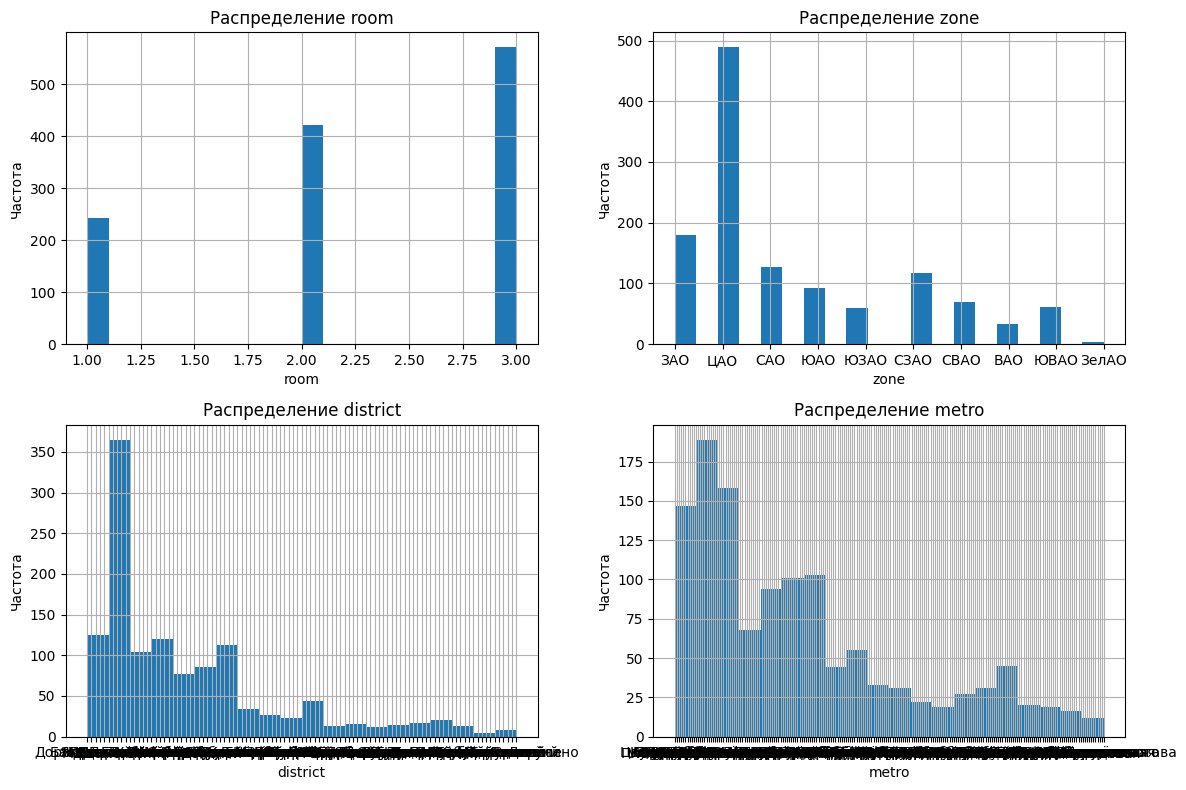

In [35]:
columns_to_plot = ['room', 'zone', 'district', 'metro']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, col in enumerate(columns_to_plot):
    ax = axs[i // 2, i % 2]  
    data_final[col].hist(bins=20, ax=ax) 
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel(col) 
    ax.set_ylabel('Частота') 

plt.tight_layout()

plt.show()

Можно заметить, что распредление категориальных признаков неравномерно, превалируют объекты из центрально части Москвы

Также посмотрим на распредление нашего таргета, т.е цены квартиры

C:\Users\Илья\AppData\Local\Temp\ipykernel_5104\2171585315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['log_price'] = np.log1p(data_final['price'])


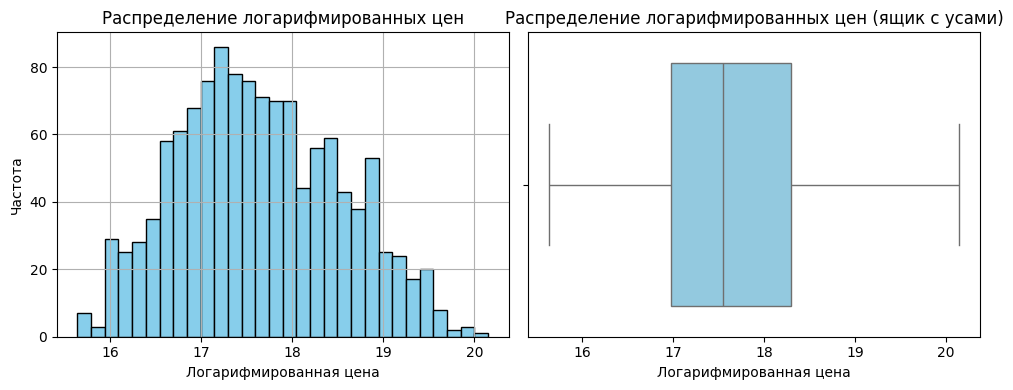

In [36]:
data_final['log_price'] = np.log1p(data_final['price'])

log_price_column = data_final['log_price']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
log_price_column.hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Распределение логарифмированных цен')
plt.xlabel('Логарифмированная цена')
plt.ylabel('Частота')

plt.subplot(1, 2, 2)
sns.boxplot(x=log_price_column, color='skyblue')
plt.title('Распределение логарифмированных цен (ящик с усами)')
plt.xlabel('Логарифмированная цена')

plt.tight_layout()

plt.show()

Логарифм распределения таргета (взят для уменьшения влияния выбросов) показывает распределение таргета похожее на нормальное

## Гипотеза 1: зависимость от площади

Первая гипотеза, которая, на первый взгляд, достаточно очевидна - это положительная зависимость стоимости квартиры от её метражности

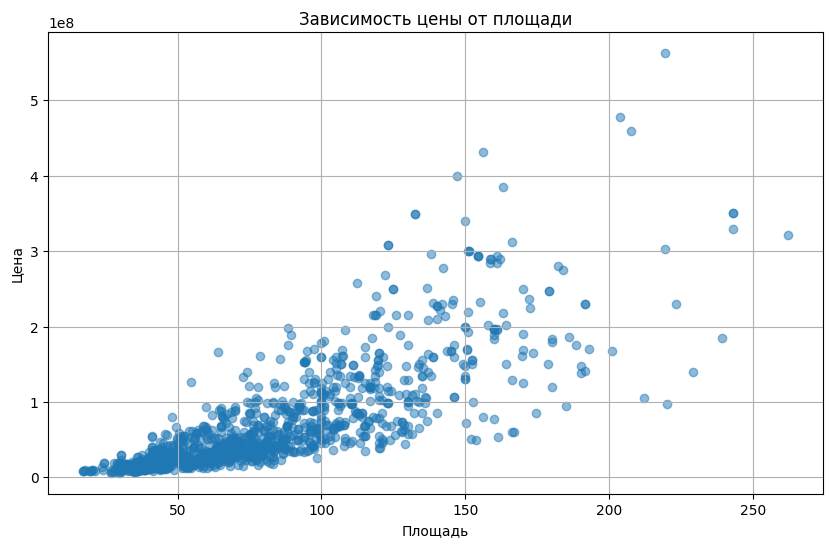

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(data_final['square'], data_final['price'], alpha=0.5) 
plt.title('Зависимость цены от площади') 
plt.xlabel('Площадь') 
plt.ylabel('Цена') 
plt.grid(True)
plt.show() 

Видим более-менее очевидную зависимость стоимость квартиры от её площади

## Гипотеза 2: зависимость стоимости от местарасположения

Следующая гипотеза заключаестся в том, что чем ближе к центру расположена квартира, тем выше её стоимость

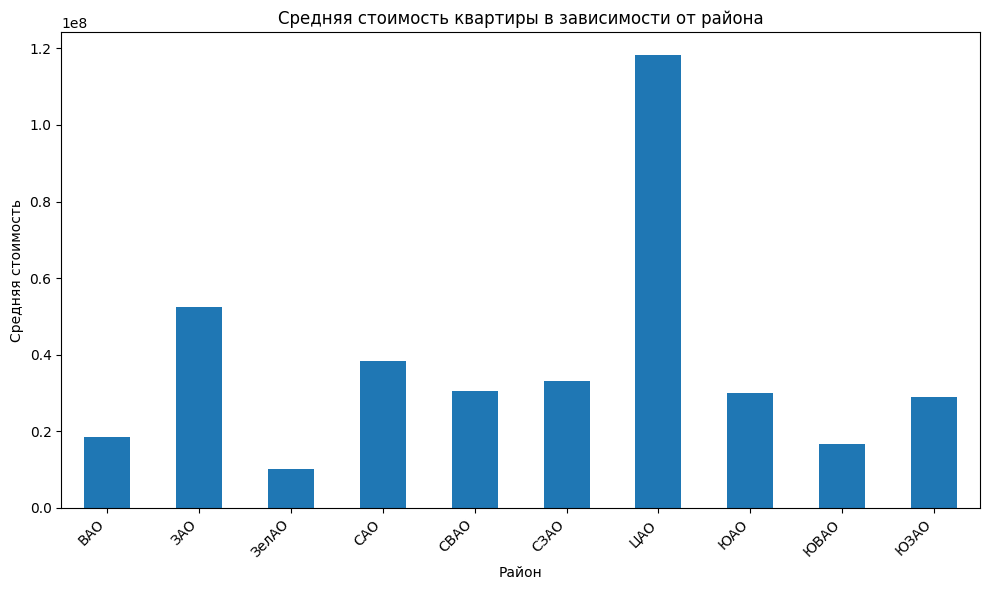

In [38]:
average_prices = data_final.groupby('zone')['price'].mean()

plt.figure(figsize=(10, 6)) 
average_prices.plot(kind='bar') 
plt.title('Средняя стоимость квартиры в зависимости от района') 
plt.xlabel('Район') 
plt.ylabel('Средняя стоимость')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Виден ярковыраженный всплеск стоимости в Центральном административном округе, что говорит о налчии зависимости расположения со стоимостью

In [39]:
len(data_final['district'].unique())

101

## Гипотеза 3: зависимость стоимости квартиры от этажа на котором она расположена и от этажности дома в целом

1. Есть гипотеза, что чем выше квартира тем она дороже, но при этом чем ниже в целом дом, тем также выше стоимость квартиры

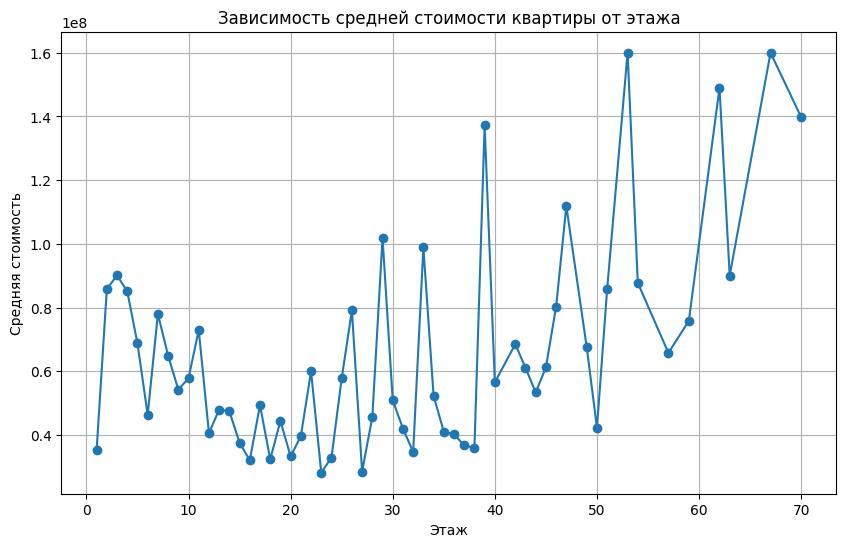

In [40]:
average_prices_by_floor = data_final.groupby('floor')['price'].mean()

plt.figure(figsize=(10, 6))
average_prices_by_floor.plot(kind='line', marker='o') 
plt.title('Зависимость средней стоимости квартиры от этажа') 
plt.xlabel('Этаж')
plt.ylabel('Средняя стоимость') 
plt.grid(True)
plt.show()

Видна закономерность, что низкие этажи и очень высокие стоят в среднем дороже, чем средние этажи, что не совсем подтверждает гипотезу, понятнее станет, когда обучим модель и посмотрим вес данного признака, возможно будет необходимо поделить его на низкие, средние и высокие этажи

2. Теперь посмотрим на зависимость цены от этажности всего здания

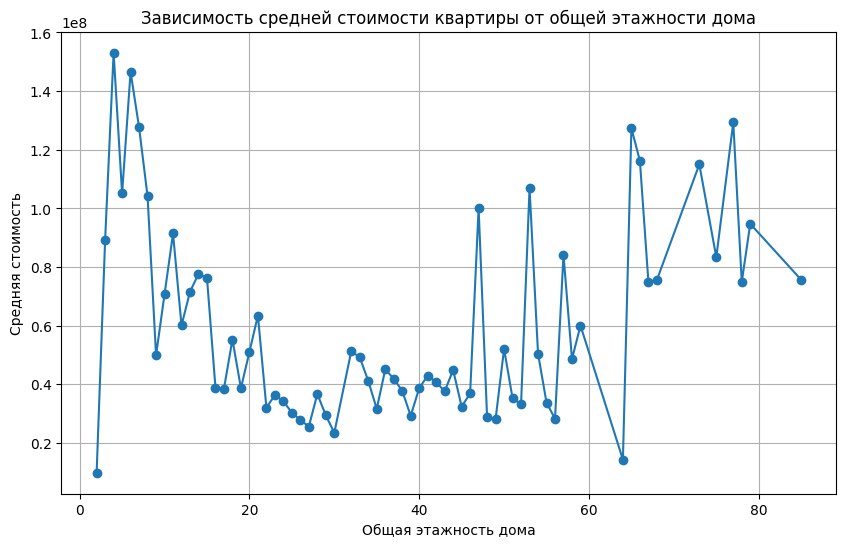

In [41]:
average_prices_by_floor_count = data_final.groupby('floor_counts')['price'].mean()

plt.figure(figsize=(10, 6))
average_prices_by_floor_count.plot(kind='line', marker='o') 
plt.title('Зависимость средней стоимости квартиры от общей этажности дома')
plt.xlabel('Общая этажность дома')
plt.ylabel('Средняя стоимость') 
plt.grid(True)
plt.show()

На графике не видно какой-либо прямой зависимости, также видна логика, что в домах средней этажности стоимость ниже, чем в низкоэтажных и в небоскрёбах выше условно 65 этажей

## Гипотеза 4: стоимость квартиры положительно зависит от расстояние до ближайшего метро

C:\Users\Илья\AppData\Local\Temp\ipykernel_5104\706831239.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['metro_range'] = pd.cut(data_final['metro_foot_minute'], bins=bins, labels=labels, include_lowest=True)
C:\Users\Илья\AppData\Local\Temp\ipykernel_5104\706831239.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_prices_by_metro_range = data_final.groupby('metro_range')['price'].mean()


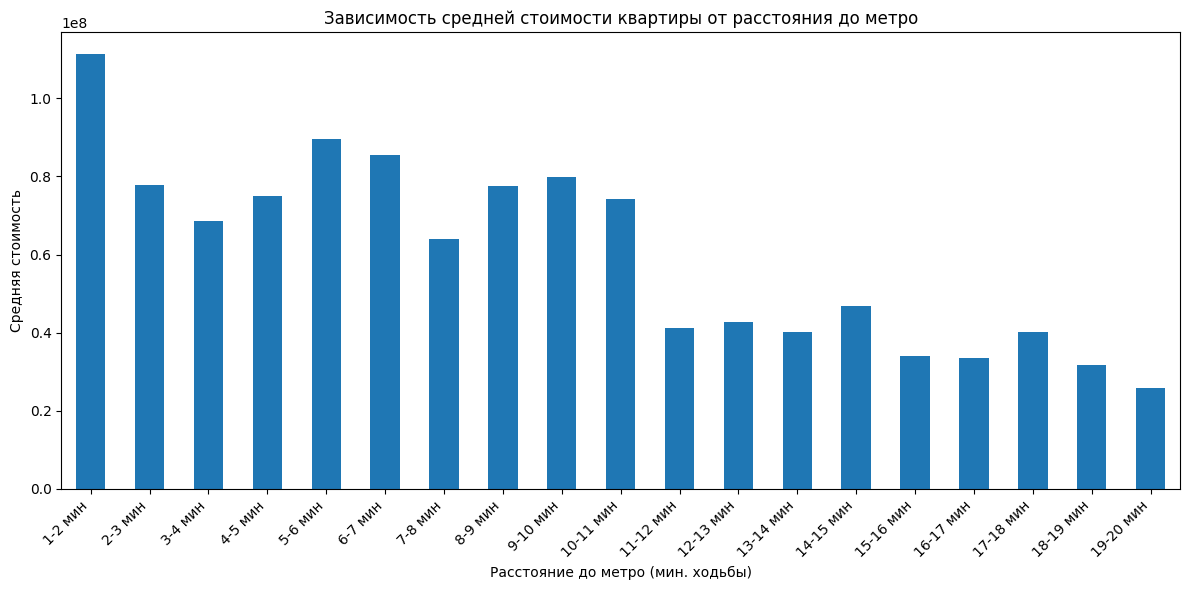

In [42]:
bins = range(1, 21)  
labels = [f'{i}-{i+1} мин' for i in bins[:-1]]  

data_final['metro_range'] = pd.cut(data_final['metro_foot_minute'], bins=bins, labels=labels, include_lowest=True)
average_prices_by_metro_range = data_final.groupby('metro_range')['price'].mean()

plt.figure(figsize=(12, 6)) 
average_prices_by_metro_range.plot(kind='bar') 
plt.title('Зависимость средней стоимости квартиры от расстояния до метро')
plt.xlabel('Расстояние до метро (мин. ходьбы)') 
plt.ylabel('Средняя стоимость') 
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show() 

Четко видна зависимость средней стоимости квартиры от времени до метро, поэтому этот призгнак будет важным при обучении линейной регресии

## Подготовка данных и обучение модели

**1. Логарифимруем целевую перменную для борьбы с выбросами**

In [43]:
data_final = data_final.drop('metro_range', axis=1)

In [44]:
data_final_log = data_final.copy()

In [45]:
data_final_log['price'] = np.log(data_final_log['price'])

**2. Теперь закодируем категориальные признаки через OHE**

In [46]:
data_final_log.head()

,room,floor,floor_counts,square,price,metro_foot_minute,zone,district,metro,log_price
0,2.0,22.0,34.0,50.60,17.897047,14.0,ЗАО,Дорогомилово,Кутузовская,17.897047
1,3.0,7.0,10.0,190.00,18.749984,5.0,ЦАО,Басманный,Бауманская,18.749984
2,2.0,2.0,14.0,85.60,18.870163,2.0,ЦАО,Якиманка,Боровицкая,18.870163
3,3.0,3.0,15.0,104.00,17.992970,7.0,САО,Аэропорт,Динамо,17.992970
4,2.0,4.0,13.0,86.28,18.438499,8.0,ЦАО,Мещанский,Цветной бульвар,18.438499


In [47]:
categorical_columns = ['room', 'zone', 'district', 'metro']
data_final_log_encoded = pd.get_dummies(data_final_log, columns=categorical_columns, drop_first=True, dtype='int64')

In [48]:
data_final_log_encoded.head()

,floor,floor_counts,square,price,metro_foot_minute,log_price,room_2.0,room_3.0,zone_ЗАО,zone_ЗелАО,...,metro_Шелепиха,metro_Шипиловская,metro_Щербинка,metro_Щукинская,metro_Щёлковская,metro_Электрозаводская,metro_Юго,metro_Южная,metro_Ясенево,metro_Яхромская
0,22.0,34.0,50.60,17.897047,14.0,17.897047,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,7.0,10.0,190.00,18.749984,5.0,18.749984,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,14.0,85.60,18.870163,2.0,18.870163,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,15.0,104.00,17.992970,7.0,17.992970,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,13.0,86.28,18.438499,8.0,18.438499,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**3. Выделим признаки и целевую перменную**

In [49]:
X = data_final_log_encoded.drop('price', axis=1)
y = data_final_log_encoded['price']

**4. Разделим выборку на обучающую и тестовую и обучим модель**

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [51]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

In [52]:
data_final_log.head()

,room,floor,floor_counts,square,price,metro_foot_minute,zone,district,metro,log_price
0,2.0,22.0,34.0,50.60,17.897047,14.0,ЗАО,Дорогомилово,Кутузовская,17.897047
1,3.0,7.0,10.0,190.00,18.749984,5.0,ЦАО,Басманный,Бауманская,18.749984
2,2.0,2.0,14.0,85.60,18.870163,2.0,ЦАО,Якиманка,Боровицкая,18.870163
3,3.0,3.0,15.0,104.00,17.992970,7.0,САО,Аэропорт,Динамо,17.992970
4,2.0,4.0,13.0,86.28,18.438499,8.0,ЦАО,Мещанский,Цветной бульвар,18.438499


**5. Посчитаем MSE на тренировочной и тестовой выборках**

In [53]:
from sklearn.metrics import mean_squared_error

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(f'MSE для тренировочной выборки: {mean_squared_error(y_train, y_pred_train)}')
print(f'MSE для тестовой выборки: {mean_squared_error(y_test, y_pred_test)}')

MSE для тренировочной выборки: 2.5420502605551226e-17
MSE для тестовой выборки: 3617.138715117576


**6. Оценим модель на переобучение, посмотрев на коэфцииенты перменных**

In [54]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

coefficients['AbsCoefficient'] = np.abs(coefficients['Coefficient'])

coefficients = coefficients.sort_values('AbsCoefficient', ascending=False)

coefficients = coefficients.drop('AbsCoefficient', axis=1)

coefficients

,Feature,Coefficient
8,zone_ЗелАО,1045.180247
75,district_Покровское,796.151255
109,district_Щукино,796.151255
103,district_Хорошево,796.151255
111,district_Южное Тушино,796.151255
...,...,...
251,metro_Реутов,0.000000
287,metro_Тургеневская,0.000000
259,metro_Семёновская,0.000000
281,metro_Тимирязевская,0.000000


Можем заметить, что веса очень большие, что может говорить о переобучении модели, поэтому нужно добавить регуляризацию. 

Будем использовать Lasso-регуляризацию, потому что она зануляет ненужные признаки, а у нас очень много признаков и таким образом мы возьмём только самые информативные.

С помощью кросс-валидации найдём самый оптимальный коэффициент альфа для регуляризации

In [55]:
from sklearn.linear_model import LassoCV, Lasso

alphas = [0.1, 1, 10, 100, 200]

lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train, y_train)

mse_path = lasso_cv.mse_path_

mean_mse = np.mean(mse_path, axis=1)

best_alpha_index = np.argmin(mean_mse)

best_alpha = lasso_cv.alphas_[best_alpha_index]

print(f"Наиболее оптимальное значение alpha: {best_alpha}")

Наиболее оптимальное значение alpha: 0.1


In [56]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [57]:
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': lasso.coef_})

coefficients['AbsCoefficient'] = np.abs(coefficients['Coefficient'])

coefficients = coefficients.sort_values('AbsCoefficient', ascending=False)

coefficients = coefficients.drop('AbsCoefficient', axis=1)

coefficients

,Feature,Coefficient
4,log_price,0.589286
2,square,0.007437
1,floor_counts,-0.001123
3,metro_foot_minute,-0.001066
0,floor,-0.000000
...,...,...
107,district_Чертаново Северное,0.000000
106,district_Черемушки,-0.000000
105,district_Царицыно,-0.000000
104,district_Хорошевский,0.000000


In [58]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

print(f'MSE для тренировочной выборки: {mean_squared_error(y_train, y_pred_train)}')
print(f'MSE для тестовой выборки: {mean_squared_error(y_test, y_pred_test)}')

MSE для тренировочной выборки: 0.0401202034187949
MSE для тестовой выборки: 0.039236135379513586


## Можно заметить, что при добавлении регуляризации, веса значительно уменьшились, а качество модеои на тестовой выборке значитльно выросло, поэтому можно утверждать, что мы обучили хорошую модель по предсказанию стоимости квартиры